# 은행 사기 탐지

은행거래에서의 사기를 판별하는 것은 실제 은행에서 매우 중요한 일이며 매우 소수가 사기(Fraud)이지만 만약 그 거래가 잘 탐지되지 않았을 때 피해는 매우 큽니다. 이 notebook을 통해 가상의 금융 거래 데이터로 데이터 분석 및 이진 분류 모델을 (binary classifier) 만들겠습니다. 데이터는 [kaggle](https://www.kaggle.com/ntnu-testimon/paysim1)에서도 받으실 수 있고, 여기서 사용된 데이터는 이미 가공을 한 번 거친 상태이기에 column이나 row 수가 다를 수 있습니다.

## 데이터 설명

이 데이터셋은 금융 응용프로그램의 연구를 돕기 위한 시뮬레이션 데이터셋으로, 9개의 컬럼으로 300개의 레코드를 갖습니다. 각 레코드는 하나의 거래를 의미하며 입금(cash in), 출금(cash out), 직불(debit), 신용(credit), 또는 송금(transfer)를 나타내고, 각 거래는 금액과 거래주체(name of origin) 등을 가집니다. 사기여부를 나타내는 ``isFraud``가 label 혹은 target column이 됩니다.

- type : 거래 유형 (CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER)
- amount : 거래 금액
- nameOrig : 거래를 시작한 주체
- oldbalanceOrg : 거래 시작 주체의 거래 이전 잔고
- newbalanceOrig : 거래 시작 주체의 거래 이후 잔고
- nameDest : 거래 대상 주체
- oldbalanceDest : 거래 대상의 거래 이전 잔고
- newbalanceDest : 거래 대상의 거래 이후 잔고
- isFraud : 사기 여부

## Setup

Notebook을 진행하기 위해 여러 라이브러리를 다운로드 합니다.

### Import libraries

In [1]:
import os                                         # For manipulating filepath names  
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs

import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.

import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
from sagemaker import get_execution_role          # Define IAM role
from sklearn.preprocessing import MinMaxScaler

import boto3

### Set boto3 and variables

세션을 연결하고 IAM (Identity and Access Management) 역할을 검색합니다. 데이터를 불러오고 저장할 ``S3 bucket의 이름`` 및 ``학번``과 같이 앞으로 사용될 값을 설정합니다.

In [2]:
sagemaker_session = sagemaker.Session()
s3 = boto3.resource('s3')
role = get_execution_role()

### 아래 값을 변경해주세요.

In [6]:
bucket = 'CHANGE TO YOUR S3 BUCKET NAME'           # 여러분의 S3 bucket 명으로 변경해주세요. 예) 'sagemaekr-workshop-성함'

In [7]:
file = 'banking_fraud.csv'                         # 불러올 파일의 이름입니다 
prefix = 'banking-fraud'                           # S3 bucket에서의 폴더명이라고 생각하시면 됩니다        

data_location = 's3://{}/{}'.format(bucket, file) 

## Data Preprocessing
### Read dataset

위의 셀에서 설정한 S3 bucket 위치에서 데이터를 불러옵니다.

In [8]:
df = pd.read_csv(data_location)

df.shape

(3000, 9)

In [9]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,CASH_OUT,140421.18,C1667570766,16004.0,0.00,C2102410298,0.00,140421.18,0
1,CASH_OUT,216666.53,C1495945377,50398.0,0.00,C814408370,10119297.16,10335963.70,0
2,CASH_OUT,234636.20,C269129885,74262.0,0.00,C1389815469,166046.48,400682.68,0
3,CASH_IN,52816.29,C129678616,117751.0,170567.29,C842027837,0.00,0.00,0
4,CASH_OUT,63871.25,C1282823885,6012.0,0.00,C1236511065,456488.36,520359.60,0


``isFraud``를 예측하는 모델을 만들 것이기에 isFraud 가 1 (True) 인 값이 얼마나 많은지 확인합니다. 전체의 11.2%가 Fraud인 것을 알 수 있습니다.

In [10]:
df['isFraud'].mean() 

0.112

## EDA (Exploratory Data Analysis, 탐색적 데이터 분석)

모델을 만들기 위해 데이터의 분포 및 평균, 어떤 feature가 있는지 등을 확인합니다. 각 feature에 대한 정보를 통해 feature engineering을 진행하게 됩니다.

In [11]:
# Frequency tables for each categorical feature
for column in df.select_dtypes(include=['object']).columns:
    print(column, len(df[column].unique()))

type 5
nameOrig 3000
nameDest 2999


각 categorical feature의 값을 확인할 수 있습니다.
- type: 5개의 카테고리가 있으므로 one-hot-encoding 으로 변형
- nameOrig, nameDest: 많은 카테고리가 존재하므로 삭제

In [12]:
# type의 카테고리 확인
column = 'type'
display(pd.crosstab(index=df[column], columns='% observations', normalize='columns'))

col_0,% observations
type,
CASH_IN,0.144667
CASH_OUT,0.311667
DEBIT,0.017000
PAYMENT,0.414667
TRANSFER,0.112000


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3000.000000
mean,2.542131e+05,3.209679e+05,1.460443e+05,6.789421e+05,8.044602e+05,0.112000
std,1.072189e+06,2.255314e+06,1.592268e+06,3.156094e+06,3.243301e+06,0.315419
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,7.515708e+03,1.035475e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,3.297213e+04,3.058350e+04,4.176675e+03,0.000000e+00,0.000000e+00,0.000000
75%,1.522532e+05,9.948825e+04,6.888302e+04,2.255525e+05,3.795359e+05,0.000000
max,1.000000e+07,5.731626e+07,4.731626e+07,1.053767e+08,1.052426e+08,1.000000


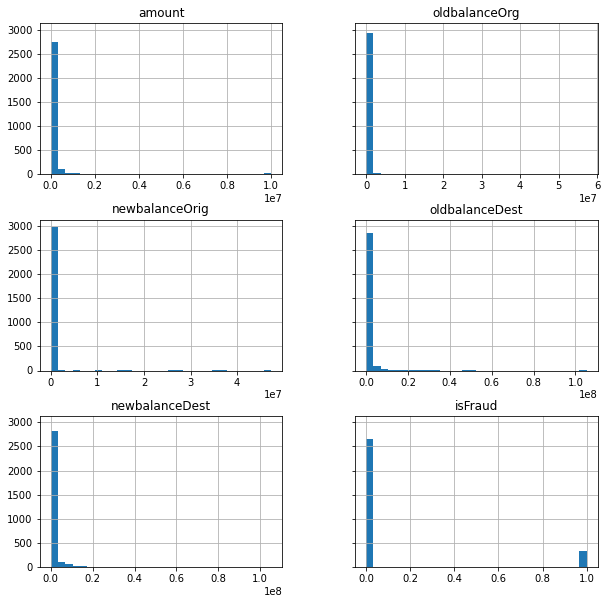

In [13]:
# 히스토그램을 통해 numeric features 의 분포 확인
display(df.describe())

%matplotlib inline
hist = df.hist(bins=30, sharey=True, figsize=(10, 10))

### Correlation 확인

각 feature 가 얼마나 유용할지 간접적으로 살펴보기 위하여 target variable 인 isFraud 와의 상관관계를 살펴봅니다.

In [14]:
y_column = 'isFraud'
x_column = 'type'
display(pd.crosstab(index=df[x_column], columns=df[y_column], normalize='columns'))

isFraud,0,1
type,,
CASH_IN,0.162913,0.0
CASH_OUT,0.287913,0.5
DEBIT,0.019144,0.0
PAYMENT,0.466967,0.0
TRANSFER,0.063063,0.5


amount


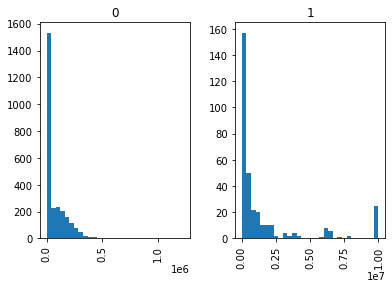

oldbalanceOrg


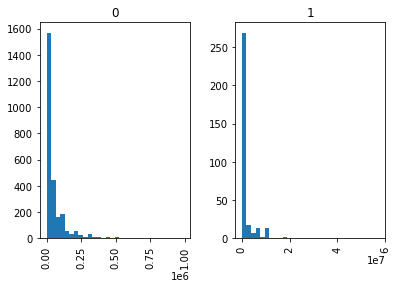

newbalanceOrig


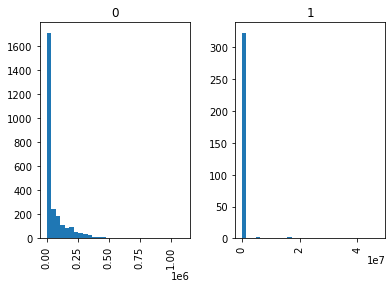

oldbalanceDest


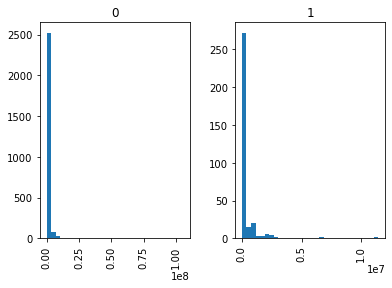

newbalanceDest


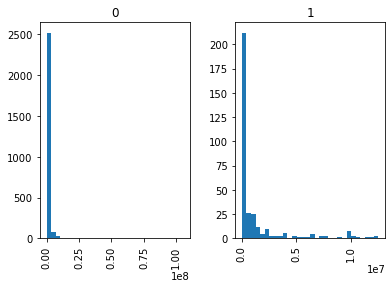

isFraud


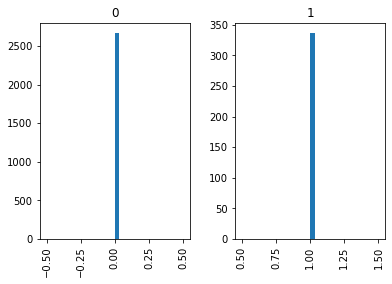

In [15]:
for column in df.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = df[column].hist(by=df[y_column], bins=30)
    plt.show()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,0.793612,0.485213,-0.010605,0.147020,0.465154
oldbalanceOrg,0.793612,1.000000,0.906651,-0.018543,0.054395,0.324129
newbalanceOrig,0.485213,0.906651,1.000000,-0.009689,-0.013352,0.143456
oldbalanceDest,-0.010605,-0.018543,-0.009689,1.000000,0.972684,-0.026609
newbalanceDest,0.147020,0.054395,-0.013352,0.972684,1.000000,0.047420
isFraud,0.465154,0.324129,0.143456,-0.026609,0.047420,1.000000


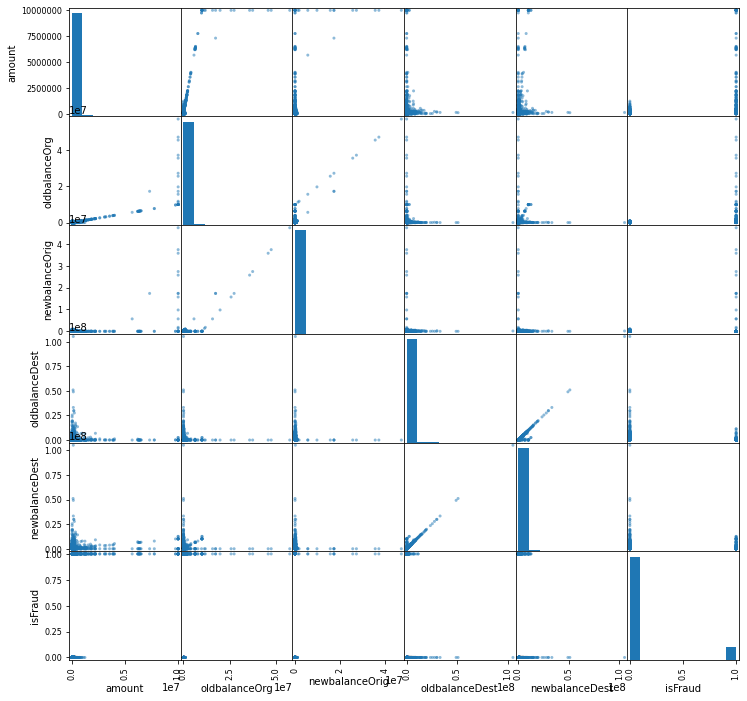

In [16]:
display(df.corr())
pd.plotting.scatter_matrix(df, figsize=(12, 12))
plt.show()

## Feature engineering

- categorical feature: type 카테고리를 one-hot encoding
- numeric feature: 정규화를 위한 min-max scaler 적용

In [17]:
one_hot = pd.get_dummies(df['type'])
one_hot.head()

,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,0,1,0,0,0


In [18]:
numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

scaler = MinMaxScaler()
transformed_data = scaler.fit_transform(df[numeric_features])
transformed_data

array([[1.40421180e-02, 2.79222709e-04, 0.00000000e+00, 0.00000000e+00,
        1.33426150e-03],
       [2.16666530e-02, 8.79296806e-04, 0.00000000e+00, 9.60297766e-02,
        9.82108144e-02],
       [2.34636200e-02, 1.29565339e-03, 0.00000000e+00, 1.57574248e-03,
        3.80722819e-03],
       ...,
       [6.31140928e-01, 1.10115521e-01, 0.00000000e+00, 6.49943163e-04,
        6.06208582e-02],
       [8.50002520e-02, 1.48300429e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [8.50002520e-02, 1.48300429e-02, 0.00000000e+00, 6.17793265e-02,
        6.99346086e-02]])

In [19]:
transformed_df = pd.DataFrame(transformed_data)
transformed_df

,0,1,2,3,4
0,0.014042,0.000279,0.000000,0.000000,0.001334
1,0.021667,0.000879,0.000000,0.096030,0.098211
2,0.023464,0.001296,0.000000,0.001576,0.003807
3,0.005282,0.002054,0.003605,0.000000,0.000000
4,0.006387,0.000105,0.000000,0.004332,0.004944
...,...,...,...,...,...
2995,0.033968,0.005926,0.000000,0.000000,0.003228
2996,0.631141,0.110116,0.000000,0.000000,0.000000
2997,0.631141,0.110116,0.000000,0.000650,0.060621
2998,0.085000,0.014830,0.000000,0.000000,0.000000


In [20]:
final_df = pd.concat([df, one_hot, transformed_df], axis = 1)
final_df.shape

(3000, 19)

In [21]:
final_df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,0,1,2,3,4
0,CASH_OUT,140421.18,C1667570766,16004.0,0.00,C2102410298,0.00,140421.18,0,0,1,0,0,0,0.014042,0.000279,0.000000,0.000000,0.001334
1,CASH_OUT,216666.53,C1495945377,50398.0,0.00,C814408370,10119297.16,10335963.70,0,0,1,0,0,0,0.021667,0.000879,0.000000,0.096030,0.098211
2,CASH_OUT,234636.20,C269129885,74262.0,0.00,C1389815469,166046.48,400682.68,0,0,1,0,0,0,0.023464,0.001296,0.000000,0.001576,0.003807
3,CASH_IN,52816.29,C129678616,117751.0,170567.29,C842027837,0.00,0.00,0,1,0,0,0,0,0.005282,0.002054,0.003605,0.000000,0.000000
4,CASH_OUT,63871.25,C1282823885,6012.0,0.00,C1236511065,456488.36,520359.60,0,0,1,0,0,0,0.006387,0.000105,0.000000,0.004332,0.004944


In [22]:
# 훈련에 필요없는 column을 삭제합니다
columns_to_drop = ['type', 'isFraud', 'nameOrig', 'nameDest']

In [23]:
# 데이터를 train, validation, test 각각 7:2:1의 비율로 나눕니다
train_data, validation_data, test_data = np.split(final_df.sample(frac=1, random_state=2021), [int(0.7 * len(final_df)), int(0.9 * len(final_df))])

Amazon SageMaker의 XGBoost 컨테이너는 libSVM 또는 CSV 포맷의 데이터를 사용합니다. 본 예제에서는 CSV를 이용합니다. CSV파일에서 첫번째 컬럼을 타겟변수 값으로 지정해야 하고, 헤더를 포함하고 있지 않아야 합니다. 본 예제에서는 데이터를 train | validation | test 데이터셋으로 분리한 후 작업합니다.

In [24]:
# 각 데이터셋을 노트북 로컬 환경에 저장합니다
pd.concat([train_data[y_column], train_data.drop(columns_to_drop, axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data[y_column], validation_data.drop(columns_to_drop, axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)
pd.concat([test_data[y_column], test_data.drop(columns_to_drop, axis=1)], axis=1).to_csv('test.csv', index=False, header=False)
pd.concat([test_data.drop(columns_to_drop, axis=1)], axis=1).to_csv('test_features.csv', index=False, header=False)

SageMaker의 관리형 학습환경에서 이 데이터에 접근할 수 있도록 파일을 S3에 업로드 합니다.

In [25]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test_features.csv')).upload_file('test.csv')

## Train a model using XGBoost

이 notebook에서는 간단하지만 이진 분류에 효과적인 XGBoost 를 사용합니다. XGBoost 는 Gradient Boosting 을 수행하는 open source library 입니다. 계산 성능이 뛰어나고 필요한 기능들을 모두 구현하고 있으며, 많은 머신러닝 경쟁에서 성공적인 성과를 보여주고 있습니다. SageMaker의 관리형, 분산 학습 프레임워크를 이용하여 학습할 수 있도록 간단한 xgboost모델을 시작해 보겠습니다.

SageMaker 의 ECR 컨테이너를 통해 해당되는 built-in 알고리즘을 사용할 수 있습니다.

In [26]:
from sagemaker import image_uris

container = sagemaker.image_uris.retrieve(framework = 'xgboost', 
                                          region = boto3.Session().region_name, 
                                          version = 'latest')

CSV 파일 포맷을 사용하므로 S3의 파일 위치를 알려주는 s3_input 오브젝트를 생성하고 콘텐츠 타입을 CSV로 지정합니다.

In [27]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

다음으로 파라미터를 지정하여 esitmator를 생성합니다.

- xgboost 알고리즘 컨테이너 사용
- 사용할 IAM 역할(role)
- 학습용 인스턴스 타입과 수량 ('local_cpu'를 사용해 해당 노트북의 인스턴스 내에서 학습을 진행할 수도 있습니다.)
- 출력데이터를 위한 S3위치
- 알고리즘 하이퍼파라미터

이제 다음 파라미터를 이용하여 .fit() 명령을 실행합니다.
- 학습용(train)/검증용(validation) 데이터가 있는 S3 위치

본 예제는 학습과 검증 데이터셋을 모두 사용하므로 두 채널을 모두 지정합니다.

In [28]:
sess = sagemaker.Session()

job_name='banking-fraud-'+strftime("%Y-%m-%d-%H-%M-%S", gmtime())

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge', 
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess,
                                    base_job_name=job_name)

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=5)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2021-10-19 00:40:06 Starting - Starting the training job...
2021-10-19 00:40:08 Starting - Launching requested ML instancesProfilerReport-1634604005: InProgress
...
2021-10-19 00:41:03 Starting - Preparing the instances for training.........
2021-10-19 00:42:36 Downloading - Downloading input data...
2021-10-19 00:42:57 Training - Downloading the training image..Arguments: train
[2021-10-19:00:43:20:INFO] Running standalone xgboost training.
[2021-10-19:00:43:20:INFO] File size need to be processed in the node: 0.31mb. Available memory size in the node: 8384.25mb
[2021-10-19:00:43:20:INFO] Determined delimiter of CSV input is ','
[00:43:20] S3DistributionType set as FullyReplicated
[00:43:20] 2100x15 matrix with 31500 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-10-19:00:43:20:INFO] Determined delimiter of CSV input is ','
[00:43:20] S3DistributionType set as FullyReplicated
[00:43:20] 600x15 matrix with 9000 entries loaded from /opt/ml/input

## Hosting
### Create endpoint

입력데이터에 대해 xgboost 모델의 학습이 완료되면 이 모델을 실시간 추론을 위한 엔드포인트로 배포합니다.

In [29]:
%%time

endpoint_name='banking-fraud-'+strftime("%Y-%m-%d-%H-%M-%S", gmtime())

xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge', 
                           endpoint_name=endpoint_name)

-----!CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 2min 31s


## Perform Inference
### Make predictions using the endpoint

머신러닝 모델의 성능을 확인하기 위해 실제값과 예측값을 비교합니다. 추론용 데이터를 엔드포인트에 전달하고 결과를 받아옵니다. 데이터를 HTTP POST request로 보내기 위해 CSV 형태로 직렬화(serialize)하고 결과로 리턴되는 CSV를 디코딩합니다.

주의: SageMaker XGBoost에서 CSV포맷으로 추론할 때 요청 데이터는 타겟속성 컬럼을 포함하지 않습니다.

In [30]:
from sagemaker.serializers import CSVSerializer

xgb_predictor.serializer = CSVSerializer()

엔드포인트를 호출하는 함수를 생성합니다.

- 테스트 데이터셋을 반복 (Loop)
- rows 만큼 미니매치로 나누기
- 미니배치를 CSV string payloads로 변환 (타겟속성 변수 제거)
- XGBoost 엔드포인트를 호출하고 예측값 수신
- CSV 결과로 리턴된 예측값을 다시 NumPy 배열로 변환

In [31]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for i, array in enumerate(split_array):
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
        if i % 10 == 0:
            print(i, 'out of', len(split_array), 'completed')
    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(columns_to_drop, axis=1).to_numpy())

0 out of 1 completed


In [32]:
# F1-score, accurancy, ROC 값을 확인합니다
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score # import classification metrics

print(classification_report(test_data[y_column], np.round(predictions)))
print("Test accuracy:", accuracy_score(test_data[y_column], np.round(predictions)))
print("ROC_AUC score:", roc_auc_score(test_data[y_column], np.round(predictions) / 1000))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       265
           1       0.91      0.86      0.88        35

    accuracy                           0.97       300
   macro avg       0.95      0.92      0.93       300
weighted avg       0.97      0.97      0.97       300

Test accuracy: 0.9733333333333334
ROC_AUC score: 0.922911051212938


예측결과와 실제값을 비교하는 Confustion matrix를 생성합니다. 알고리즘의 샘플링과정에서 랜덤요소가 반영되므로 결과의 숫자는 위 결과와 정확히 동일하지 않을 수 있습니다.

In [33]:
pd.crosstab(index=test_data['isFraud'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0,262,3
1,5,30


TP, TN, FP, FN 은 다음과 같이 정의 되어 있습니다.

- TP = Truly (identified as) Positive
- TN = Truly (identified as) Negative
- FP = Falsely (identified as) Positive
- FN = Falsely (identified as) Negative

위의 테이블의 각 셀에 해당하는 것을 표시하였습니다.

| actuals\predictions | 0 | 1 |
| --- | --- | --- |
| 0 | TN | FP |
| 1 | FN | TP |


이를 바탕으로 Accuracy, Precision, Recall 을 측정할 수 있습니다.
- Accuracy = (TP + TN) / (TP + FP + FN + TP)
- Precision = TP / (TP + FP) = 670 / (670 + 29)
- Recall = TP / (TP + FN) = 670 / (670 + 157)

## Stop / Close the Endpoint

본 예제를 모두 마무리한 후 아래 셀을 실행합니다. 다음 명령은 추론 단계에서 생성한 SageMaker에서 호스팅되고 있는 엔드포인트를 제거합니다. 엔드포인트를 삭제하지 않으면 계속 사용요금이 발생할 수 있습니다.

In [34]:
# sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
